In [1]:
#!pip install -r requirements.txt

In [2]:
import numpy as np
from EdgeML.tf.edgeml_tf.graph.bonsai import Bonsai
from EdgeML.tf.edgeml_tf.trainer.bonsaiTrainer import BonsaiTrainer
import tensorflow as tf

In [3]:
# Example dataset
X_train = np.random.randn(446, 3)  # Replace with your actual dataset
y_train = np.random.randint(0, 2, size=(446, 1))  # Binary labels

# Convert the data into TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)


In [4]:
sigma = 1.0 #Sigmoid parameter for tanh
depth = 3 #Depth of Bonsai Tree
projectionDimension = 28 #Lower Dimensional space for Bonsai to work on

#Regularizers for Bonsai Parameters
regZ = 0.0001
regW = 0.001
regV = 0.001
regT = 0.001

totalEpochs = 100

learningRate = 0.01

outFile = None

#Sparsity for Bonsai Parameters. x => 100*x % are non-zeros
sparZ = 0.2
sparW = 0.3
sparV = 0.3
sparT = 0.62

batchSize = np.maximum(100, int(np.ceil(np.sqrt(y_train.shape[0]))))

useMCHLoss = True #only for Multiclass cases True: Multiclass-Hing Loss, False: Cross Entropy. 

numClasses = 2  # Binary classification
dataDimension = X_train.shape[1]  # Number of features in your data
projDimension = 5  # Dimension for projection, can be tuned
depth = 3  # Depth of the decision tree



In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

AttributeError: module 'tensorflow' has no attribute 'InteractiveSession'

In [ ]:
# Initialize the Bonsai model
bonsaiObj = Bonsai(numClasses, dataDimension, projDimension, depth, sigma)

# Initialize the trainer
bonsaiTrainer = BonsaiTrainer(bonsaiObj, regW, regT, regV, regZ, sparW, sparT, sparV, sparZ,
                              learningRate, X_train, y_train, useMCHLoss, outFile)

In [ ]:
bonsaiTrainer.train(batchSize, totalEpochs, sess,
                    X_train, X_train, X_train, X_train)

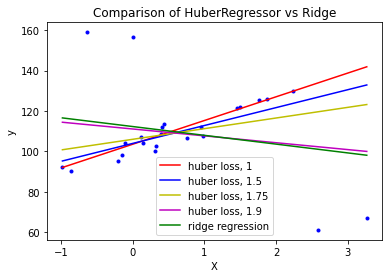

In [6]:
# Authors: Manoj Kumar mks542@nyu.edu
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor, Ridge

# Generate toy data.
rng = np.random.RandomState(0)
X, y = make_regression(
    n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0
)

# Add four strong outliers to the dataset.
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.0
X_outliers[2:, :] += X.min() - X.mean() / 4.0
y_outliers[:2] += y.min() - y.mean() / 4.0
y_outliers[2:] += y.max() + y.mean() / 4.0
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))
plt.plot(X, y, "b.")

# Fit the huber regressor over a series of epsilon values.
colors = ["r-", "b-", "y-", "m-"]

x = np.linspace(X.min(), X.max(), 7)
epsilon_values = [1, 1.5, 1.75, 1.9]
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(alpha=0.0, epsilon=epsilon)
    huber.fit(X, y)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)

# Fit a ridge regressor to compare it to huber regressor.
ridge = Ridge(alpha=0.0, random_state=0)
ridge.fit(X, y)
coef_ridge = ridge.coef_
coef_ = ridge.coef_ * x + ridge.intercept_
plt.plot(x, coef_, "g-", label="ridge regression")

plt.title("Comparison of HuberRegressor vs Ridge")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

In [8]:
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.datasets import make_regression
rng = np.random.RandomState(0)
X, y, coef = make_regression(
    n_samples=200, n_features=2, noise=4.0, coef=True, random_state=0)
X[:4] = rng.uniform(10, 20, (4, 2))
y[:4] = rng.uniform(10, 20, 4)
huber = HuberRegressor().fit(X, y)
huber.score(X, y)
huber.predict(X[:1,])

print("True coefficients:", coef)
print("Huber coefficients:", huber.coef_)


True coefficients: [20.4923687  34.16981149]
Huber coefficients: [17.79064252 31.01066091]


In [10]:
def generate_cpp_code(coefficients, intercept, num_features):
    """
    Generates C++ code from model coefficients and intercept.
    
    Parameters:
    coefficients (list or array): List of model coefficients
    intercept (float): Model intercept
    num_features (int): Number of features in the model
    """
    cpp_code = []

    # Add C++ code for coefficients array
    cpp_code.append("// Coefficients from the trained model")
    cpp_code.append(f"float coefficients[] = {{{', '.join(map(str, coefficients))}}};")

    # Add C++ code for intercept
    cpp_code.append(f"float intercept = {intercept};")

    # Add C++ function for prediction
    cpp_code.append("""
float predict(float features[], int num_features) {
    float result = intercept;
    for (int i = 0; i < num_features; i++) {
        result += coefficients[i] * features[i];
    }
    return result;
}
    """)



    # Join everything into one code block
    return '\n'.join(cpp_code)


# Example usage:
coefficients =  huber.coef_  # Example coefficients
intercept = huber.intercept_  # Example intercept
num_features = len(coefficients)

cpp_code = generate_cpp_code(coefficients, intercept, num_features)

# Save the generated C++ code to a file or print it
with open("generated_model_code.cpp", "w") as f:
    f.write(cpp_code)

print(cpp_code)


// Coefficients from the trained model
float coefficients[] = {17.79064252060616, 31.010660912432478};
float intercept = -0.7154312893732782;

float predict(float features[], int num_features) {
    float result = intercept;
    for (int i = 0; i < num_features; i++) {
        result += coefficients[i] * features[i];
    }
    return result;
}
    


In [ ]:
    # Add example setup function
    cpp_code.append(f"""
void setup() {{
    Serial.begin(115200);

    // Sample input features
    float sample_input[{num_features}] = {{/* Replace with actual input values */}};
    
    // Predict using the model
    float prediction = predict(sample_input, {num_features});

    Serial.print("Predicted value: ");
    Serial.println(prediction);
}}

void loop() {{
    // Do nothing in loop
}}
    """)